**Table of contents**<a id='toc0_'></a>    
- [Analyses exploratoires](#toc1_)    
  - [Lien score nutritionnel et métriques nutritionnelles](#toc1_1_)    
    - [Corrélation 2 à 2](#toc1_1_1_)    
    - [Clusters](#toc1_1_2_)    
    - [Variance métriques nutritionnelles](#toc1_1_3_)    
    - [Test des relations entre métriques nutritionnelles et score nutritionnel](#toc1_1_4_)    
- [Fusion des différentes informations](#toc2_)    
- [Application](#toc3_)    
  - [Exemple](#toc3_1_)    
    - [Nouvelle entrée](#toc3_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import math
import plotly.express as px
from scipy.spatial import ConvexHull
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import pickle

In [69]:
def scaleVector(vec):
    mean = vec.mean()
    sd = vec.std()
    vec = vec.apply(lambda x : np.nan if math.isnan(x) else (x - mean)/sd)
    return vec

def dataFrameDuplicated(data, label, keep = False):
    return data[data[label].duplicated(keep=keep)]

def removeNonASCII(data, label):    
    # convert the float values to strings
    data[label] = data[label].astype(str)    
    # remove rows where the values in column A are not ASCII
    data = data.drop(data[~data[label].apply(lambda x: x.isascii())].index)
    # display the resulting dataframe
    return(data)

def sampleDataFrame(data, data_size):
    sample = np.random.randint(data.shape[0], size= int(data_size) )
    sampled_data = data.iloc[sample]
    return sampled_data

def splitDataFrame(data, train_size = 0.8):
    toPick = round((data.shape[0]*80)/100, 0)
    train = np.random.randint(data.shape[0], size= int(toPick) )
    test = range(0,data.shape[0])
    test = list(set(test) - set(train))
    train = data.iloc[train]
    test = data.iloc[test]
    return test, train

def splitDataArray(X, y, train_size = 0.8):
    from sklearn.model_selection import train_test_split
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size = train_size)
    return xtrain, xtest, ytrain, ytest

################################################################################
######### KNN Functions
################################################################################

def KNNTestNeighbors(X, Krange = range(2, 10)):
    from sklearn import neighbors
    from sklearn.cluster import KMeans
    intertia = []
    list(Krange)
    for i in Krange :
        kmeans = KMeans(n_clusters=i,n_init=1)
        kmeans.fit(X) 
        intertia.append(kmeans.inertia_)
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    ax.set_ylabel("intertia")
    ax.set_xlabel("n_cluster")
    ax = plt.plot(Krange, intertia)
    
def KNN(xtrain, ytrain,  n_neighbors):
    from sklearn import neighbors
    knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(xtrain, ytrain)
    print(1 - knn.score(xtrain,ytrain))
    return knn

def KNNPrediction(knn, xtest, ytest):
    # On récupère les prédictions sur les données test
    predicted = knn.predict(xtest)

    # On redimensionne les données sous forme d'images
    images = xtest.values.reshape((-1, 28, 28))

    # On selectionne un echantillon de 12 images au hasard
    select = np.random.randint(images.shape[0], size=12)

    # On affiche les images avec la prédiction associée
    fig,ax = plt.subplots(3,4)

    for index, value in enumerate(select):
        plt.subplot(3,4,index+1)
        plt.axis('off')
        plt.imshow(images[value],cmap=plt.cm.gray_r,interpolation="nearest")
        plt.title('Predicted: {}'.format( predicted[value]) )

    plt.show()    
    
    # on récupère les données mal prédites 
    misclass = (ytest != predicted)
    misclass_images = images[misclass,:,:]
    misclass_predicted = predicted[misclass]

    # on sélectionne un échantillon de ces images
    select = np.random.randint(misclass_images.shape[0], size=12)

    # on affiche les images et les prédictions (erronées) associées à ces images
    for index, value in enumerate(select):
        plt.subplot(3,4,index+1)
        plt.axis(off)
        plt.imshow(misclass_images[value],cmap=plt.cm.gray_r,interpolation="nearest")
        plt.title('Predicted: {}'.format(misclass_predicted[value]) )

    plt.show()

################################################################################
######### PCA Functions
################################################################################
def pareto(data) :

    from matplotlib.ticker import PercentFormatter

    import numpy as np

    y = list(data)

    x = range(len(data))

    ycum = np.cumsum(y)/sum(y)*100

    fig, ax = plt.subplots()

    ax.bar(x,y,color="yellow")

    ax2 = ax.twinx()

    ax2.plot(x,ycum, color="C1", marker="D", ms=7)

    ax2.axhline(y=80,color="r")

    ax2.yaxis.set_major_formatter(PercentFormatter())

    ax.tick_params(axis="y", colors="C0")

    ax2.tick_params(axis="y", colors="C1")

    plt.ylim(0,110)

    plt.show()
    return fig

def biplot(pca, x_y, features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

def FactorialPlanes(X_projected, x_y, pca=None,  labels = None, clusters=None, alpha=1, figsize=[10,8],  marker=".", size = 10 ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sn.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

def pca(X, n_components = 5, x_y = (0,1), labels = None):
    mypca = PCA(n_components=n_components)
    mypca.fit(X)
    print("Valeurs de variance par axes: \n ", mypca.singular_values_)
    print("Pourcentages expliqué par axes: \n ", mypca.explained_variance_ratio_) 
    print("Bruit estimé lié à la covariance: \n ", mypca.noise_variance_)
    
    x = mypca.fit_transform(X)
    cos_sq = x**2 / np.sum(x**2, axis = 1)[:, np.newaxis]

    p1 = pareto(mypca.explained_variance_ratio_)
    plt.show(p1)
    p2 = biplot(mypca, x_y, labels)
    plt.show(p2)
    p3 = FactorialPlanes(x, x_y, pca=mypca, size = cos_sq)

    
    return mypca, p1, p2

# <a id='toc1_'></a>[Analyses exploratoires](#toc0_)
## <a id='toc1_1_'></a>[Lien score nutritionnel et métriques nutritionnelles](#toc0_)
On va explorer le lien entre le score nutritionnel et les métriques nutritionnelles:
-   A travers leur corrélation 2 à 2
-   A travers l'exploration des métriques qui expliquent le mieux la variance entre produits (ACP)
-   A travers un test pour évaluer quelles sont les métriques qui expliquent significativement le score nutritionnel
  
### <a id='toc1_1_1_'></a>[Corrélation 2 à 2](#toc0_)

In [79]:
input1 = open("dataKNN.pickle", "rb")
tmp = pickle.load(input1)
input1.close()

In [80]:
tmp.columns = [w.replace("_100g", "") for w in tmp.columns.tolist()]
tmp.columns = [w.replace("-", "_") for w in tmp.columns.tolist()]

<AxesSubplot: >

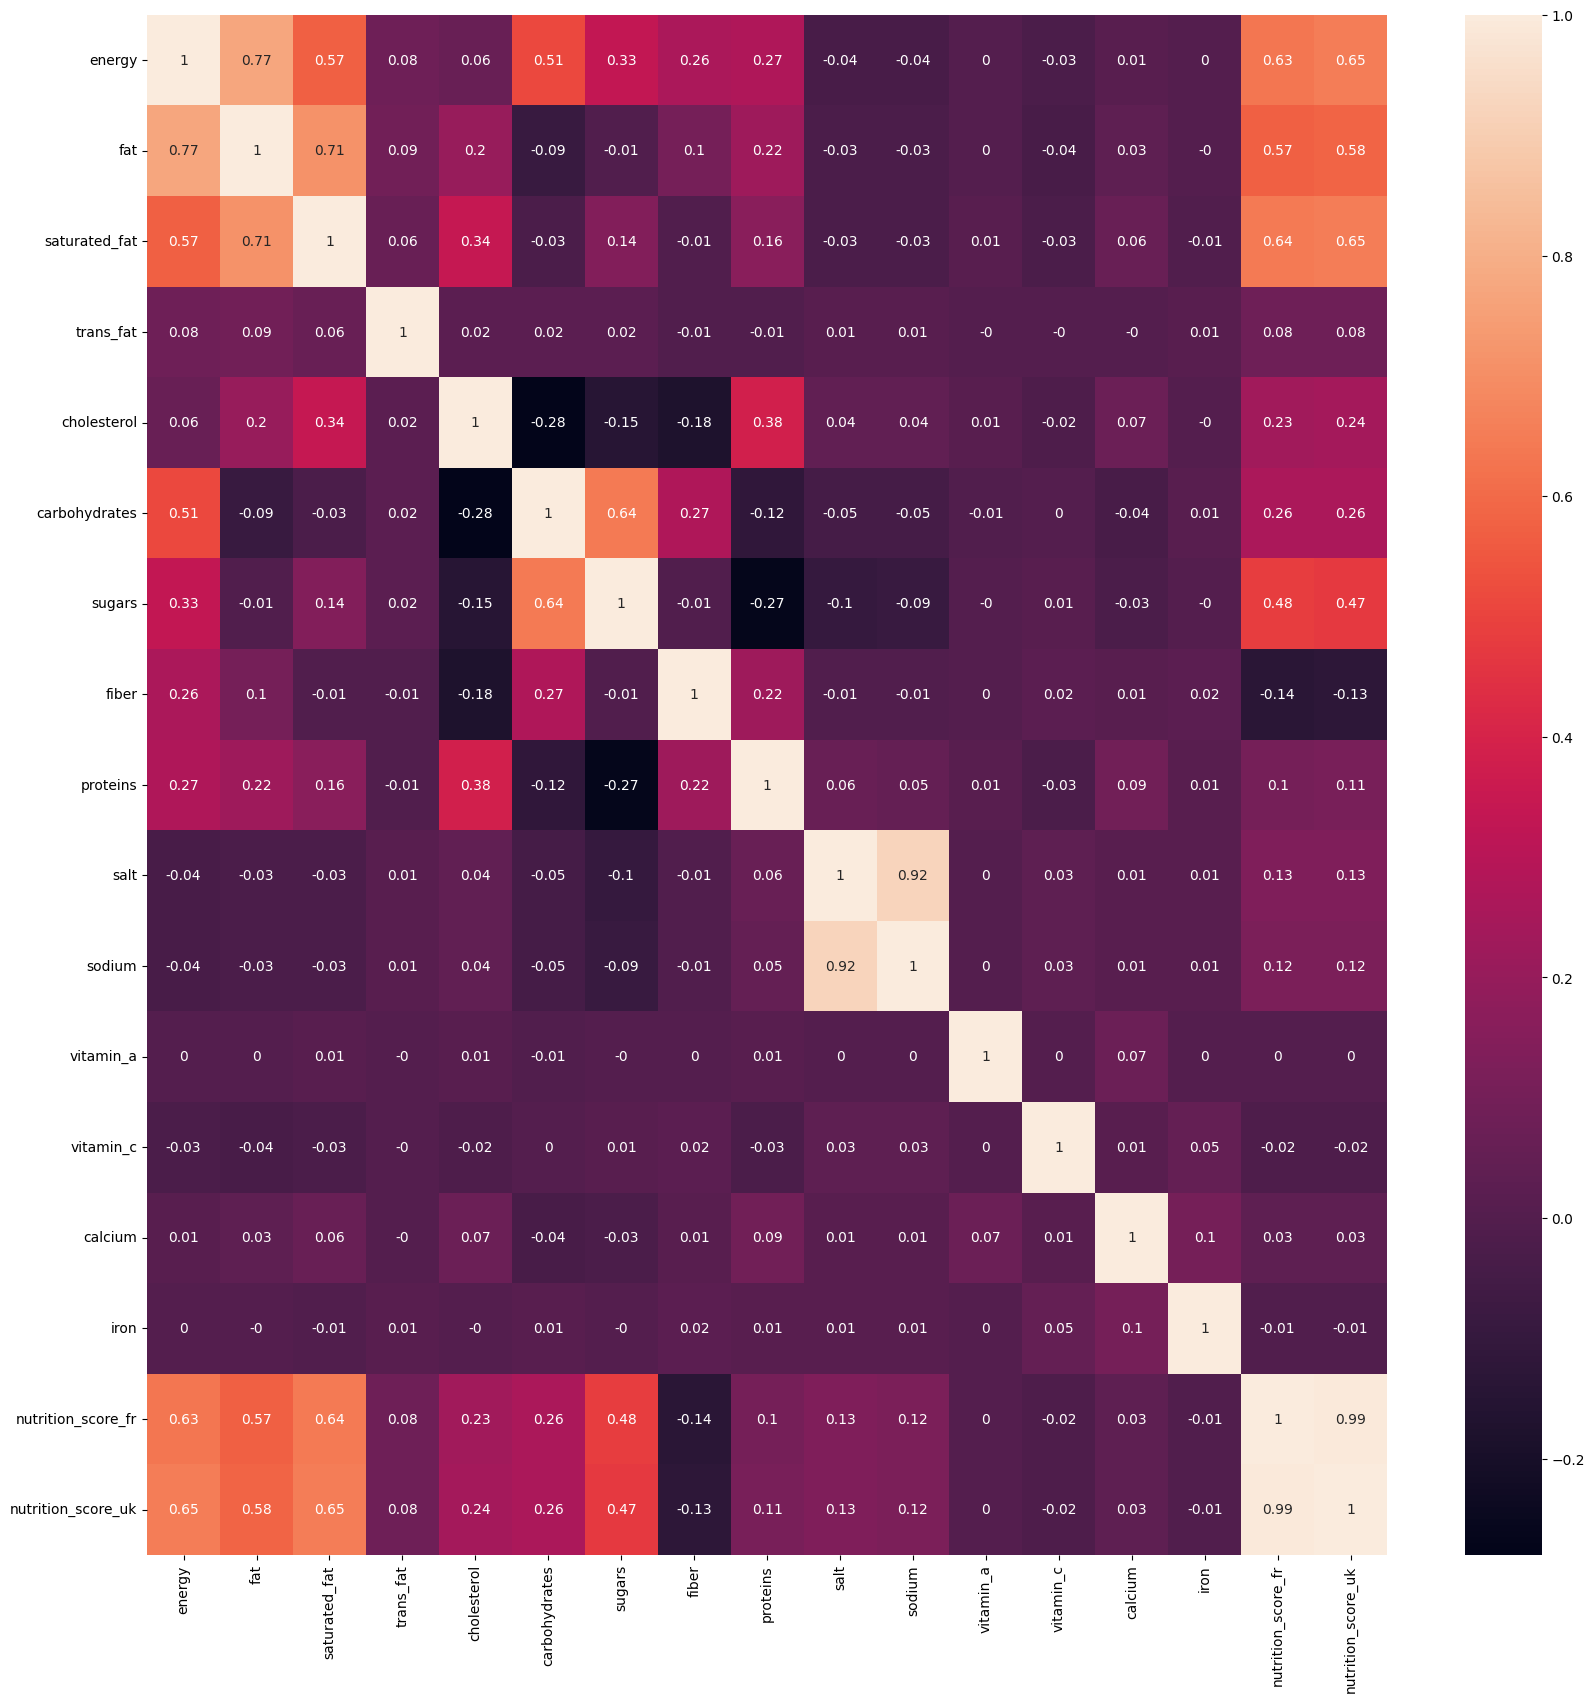

In [81]:
matrix = tmp.corr().round(2)
plt.figure(figsize=(20,20))
sn.heatmap(matrix, annot=True)

On peut voir une forte correlation entre les graisses et le score energétique, celui-ci devrait donc être un facteur déterminant pour expliquer la variance et donc être significatif dans notre modèle de régression linéaire.
On peut également voir une forte correlation entre sodium et sel.

### <a id='toc1_1_2_'></a>[Clusters](#toc0_)

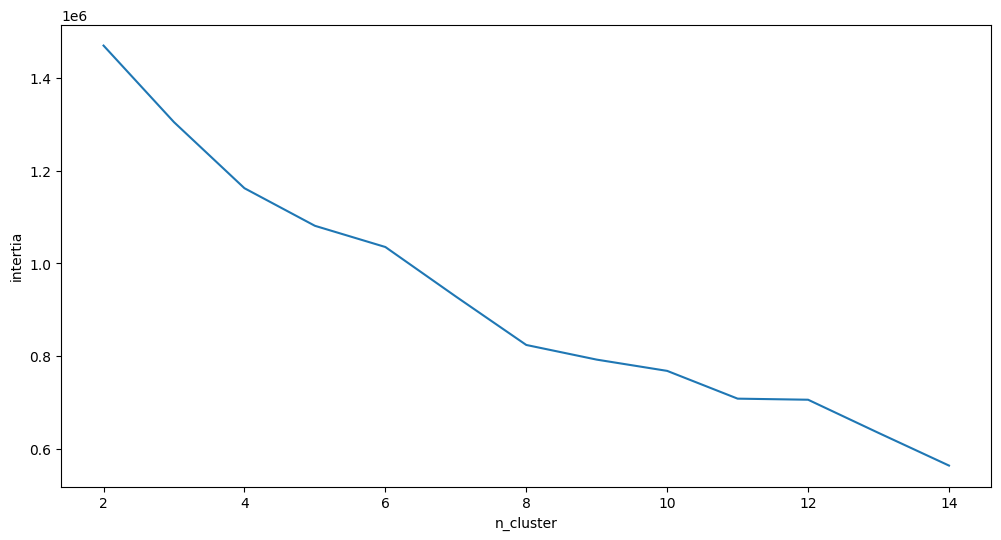

In [82]:
KNNTestNeighbors(tmp.iloc[:,2:-2], Krange = range(2, 15))

Pas de cassure visible, pas de groupes claire on ne pourra pas faire d’ANOVA, testons une ACP pour réduire le nombre de variables plutôt.
De même vue le nombre de points, on ne va pas tester une claissification hiérarchique.

### <a id='toc1_1_3_'></a>[Variance métriques nutritionnelles](#toc0_)

Valeurs de variance par axes: 
  [521.61311374 495.81931761 451.66118951 397.61726678 382.23811624]
Pourcentages expliqué par axes: 
  [0.1667183  0.15063752 0.12500052 0.09687612 0.08952705]
Bruit estimé lié à la covariance: 
  0.5292987810916965


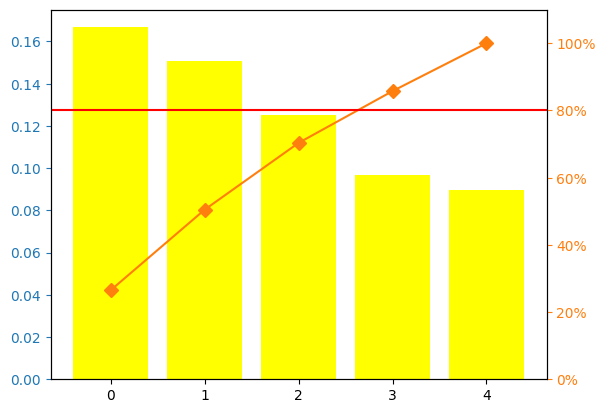

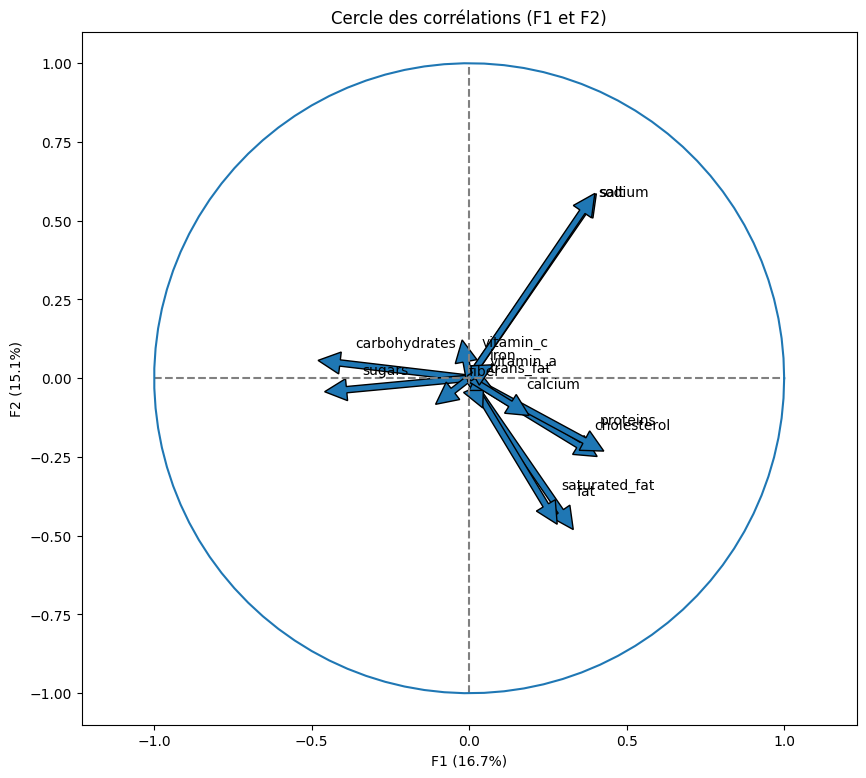

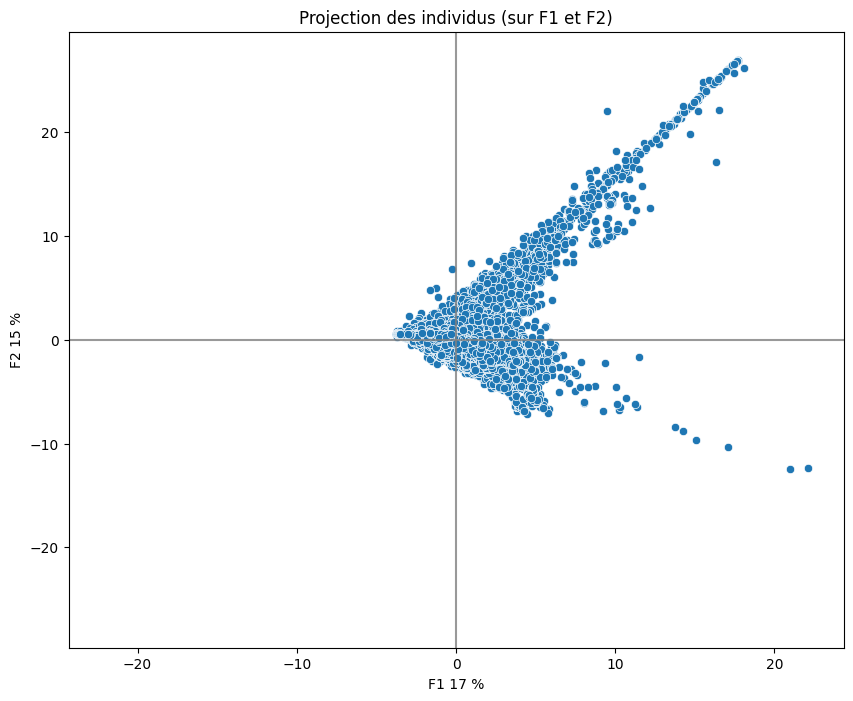

(PCA(n_components=5), <Figure size 640x480 with 2 Axes>, None)

In [84]:
pca(tmp.iloc[:,2:-2],n_components = 5, labels = tmp.iloc[:,2:-2].columns)


Il faudrais prendre les quatres premiers axes pour pouvoir expliquer plus 80% de la variance

### <a id='toc1_1_4_'></a>[Test des relations entre métriques nutritionnelles et score nutritionnel](#toc0_)

In [86]:
test, train = splitDataFrame(tmp)

In [87]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
mod = smf.ols(formula='nutrition_score_fr ~  fat + saturated_fat + trans_fat + cholesterol + carbohydrates + sugars + fiber + proteins + salt + sodium + vitamin_a + vitamin_c + calcium + iron', data=train)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     nutrition_score_fr   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                 1.765e+04
Date:                Fri, 30 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:05:10   Log-Likelihood:                -80975.
No. Observations:              101746   AIC:                         1.620e+05
Df Residuals:                  101731   BIC:                         1.621e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0631      0.002     36.374

On a un modèle qui explique 70% de la variance du nutrition_score_fr, où : 

-    Les métriques suivantes l'affecte significativement: fat, saturated_fat, trans_fat, cholesterol, carbohydrates, sugars, fiber, proteins,salt,sodium et calcium    
-    Un effet négatif significatif des métriques nutritionelles sur le score nutritionnel est lié aux fibres uniquement (les autres métriques nutritionnelles affectent positivement le score nutritionnel)

Les indices étant normalisés, on peut comparer leurs effets entre eux et le modèle nous indique que la métrique nutritionnelle qui affecte le plus le score nutritionnel est la quantité de sucre pour 100g avec une augmentation de 0.77 d'énergie par augmentation de 1 du sucre.

Par ailleurs nous avons une équation permettant de prédire le score nutritionnel en fonction des métriques nutritionnelles de la forme:
- score nutritionnel = 0.0634 + fat*0.3731 +  saturated_fat*0.2910  + ... + iron*-0.0034 + erreur     

Avec la fonction predict on peut tester la fiabilité du modèle comme suit:

In [88]:
prediction = res.predict(exog= test.iloc[:, 2:-2])

Sauvegarde du modèle

In [89]:
#model = open("model.pickle", "wb")
#pickle.dump(res, model)
#dataKNN.close()
res.save("model.pickle")

# <a id='toc2_'></a>[Fusion des différentes informations](#toc0_)

In [92]:
input = open("PalmOil.pickle", "rb")
data = pickle.load(input)
input.close()
input = open("recyclability.pickle", "rb")
recyclability = pickle.load(input)
input.close()

In [93]:
t = pd.merge(tmp, recyclability, on = "product_name", how='left')
t = pd.merge(t, data.loc[:,["product_name","ingredients_from_palm_oil_n"]], on = "product_name", how='left')
t.rename(columns={'ingredients_from_palm_oil_n': 'Palm_oil'}, inplace=True)
t

,product_name,energy,fat,saturated_fat,trans_fat,cholesterol,carbohydrates,sugars,fiber,proteins,salt,sodium,vitamin_a,vitamin_c,calcium,iron,nutrition_score_fr,nutrition_score_uk,recyclability,Palm_oil
0,Peanuts,1.481236,1.727431,0.046828,-0.103215,-0.552213,-0.182794,-0.192554,1.120542,1.836752,-0.069325,-0.068274,-0.009511,-0.033146,-0.078823,-0.008560,0.465667,0.468159,0.5,0.0
1,Peanuts,1.481236,1.727431,0.046828,-0.103215,-0.552213,-0.182794,-0.192554,1.120542,1.836752,-0.069325,-0.068274,-0.009511,-0.033146,-0.078823,-0.008560,0.465667,0.468159,0.5,0.0
2,Peanuts,1.481236,1.727431,0.046828,-0.103215,-0.552213,-0.182794,-0.192554,1.120542,1.836752,-0.069325,-0.068274,-0.009511,-0.033146,-0.078823,-0.008560,0.465667,0.468159,0.5,0.0
3,Peanuts,1.481236,1.727431,0.046828,-0.103215,-0.552213,-0.182794,-0.192554,1.120542,1.836752,-0.069325,-0.068274,-0.009511,-0.033146,-0.078823,-0.008560,0.465667,0.468159,0.5,0.0
4,Peanuts,1.481236,1.727431,0.046828,-0.103215,-0.552213,-0.182794,-0.192554,1.120542,1.836752,-0.069325,-0.068274,-0.009511,-0.033146,-0.078823,-0.008560,0.465667,0.468159,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323271,Organic Z Bar,0.232479,-0.235659,-0.426714,-0.103215,-0.552213,0.920623,0.718216,1.191583,-0.255168,-0.090140,-0.087368,0.000534,0.271986,0.746198,0.011856,0.157958,0.162973,NaN,0.0
323272,Natural Cassava,0.341914,-0.823152,-0.782292,-0.103215,-0.552213,1.837102,-0.729639,0.391480,-0.805800,-0.330518,-0.307884,-0.010803,-0.060975,-0.159651,-0.016329,-1.165771,-1.149902,NaN,0.0
323273,Tartines craquantes bio au sarrasin,0.558176,-0.653915,-0.705548,-0.103215,-0.259575,1.404114,-0.716808,0.658181,0.680152,-0.161183,-0.152541,-0.005996,-0.004891,0.024397,0.002789,-1.496703,-1.478121,0.5,NaN
323274,Test NF App,-0.841018,1.050538,-0.201089,-0.103215,0.052572,-0.806736,-0.357539,-0.408622,-0.690142,-0.051685,-0.052091,0.007472,0.081005,-0.088291,-0.002591,-0.305347,-0.296533,NaN,0.0


Sauvegarde du tableau final

In [ ]:
dataFinal = open("dataFinal.pickle", "wb")
pickle.dump(t, dataFinal)
dataFinal.close()

# <a id='toc3_'></a>[Application](#toc0_)
L'application va faire une fiche produit regroupant les informations suivantes:
- Score nutritionnel
- Métriques nutritionnelles
- Présence d'huile de palme
- Recyclabilité du produit
  
L'application va pouvoir cacluler le score nutritionnel si l'on indique les métriques nutritionnelles

In [98]:
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import plotly.express as px
def scaleVector(vec):
    '''
    vec un vecteur
    '''
    mean = vec.mean()
    sd = vec.std()
    vec = vec.apply(lambda x : np.nan if math.isnan(x) else (x - mean)/sd)
    return vec

def loadData():
    input1 = open("dataFinal.pickle", "rb")
    t = pickle.load(input1)
    input1.close()
    #for a in range(t.shape[1]):
    #    if a > 0:
    #        t.iloc[:, a] = scaleVector(t.iloc[:, a])
    
    # Load data
    res = sm.load('model.pickle')
    return t, res

def predNutritionScore(df):


    '''
    df est un tableau de 14 colonnes contenant les valeurs dans l'ordre :
        fat, saturated_fat, trans_fat, cholesterol, carbohydrates, sugars, fiber, proteins, salt, sodium, vitamin_a, vitamin_c, calcium , iron
    La fonction renvoit une array de longueur égale au nombre de lignes de l'argument df avec la prédiction du score nutritionnel
    '''
    
    predictions = res.predict(exog= df)
    return predictions

def radarPlot(df, ligne = 0 , title = ""):    
    '''
    df est un tableau contenant les métriques nutritionnelles
    ligne sont les lignes à sélectionner
    La fonction renvoit "radar plot" pour visualiser les métriques nutritionnelles
    '''
    t = pd.DataFrame(dict(value = df.iloc[ligne,].values, label= df.columns))
    ax = px.line_polar(t, r='value', theta='label', line_close=True, title = title,template = 'ggplot2' )
    return ax

## <a id='toc3_1_'></a>[Exemple](#toc0_)
### <a id='toc3_1_1_'></a>[Nouvelle entrée](#toc0_)

In [99]:
t, res = loadData()

In [101]:
new = t[(t.recyclability == 1) & (t.Palm_oil== True)].iloc[0:1,].drop(columns = ["nutrition_score_fr",	"nutrition_score_uk"])
new

,product_name,energy,fat,saturated_fat,trans_fat,cholesterol,carbohydrates,sugars,fiber,proteins,salt,sodium,vitamin_a,vitamin_c,calcium,iron,recyclability,Palm_oil
18396,Quiche Lorraine,-0.238028,0.121783,0.148664,-0.103215,1.616353,-0.605483,-0.741073,-0.433495,0.154953,-0.055889,-0.055969,-0.008092,-0.058649,0.004738,-0.021121,1,1.0


In [102]:
new["nutritionScore"] = res.predict(exog=  new)

In [103]:
new

,product_name,energy,fat,saturated_fat,trans_fat,cholesterol,carbohydrates,sugars,fiber,proteins,salt,sodium,vitamin_a,vitamin_c,calcium,iron,recyclability,Palm_oil,nutritionScore
18396,Quiche Lorraine,-0.238028,0.121783,0.148664,-0.103215,1.616353,-0.605483,-0.741073,-0.433495,0.154953,-0.055889,-0.055969,-0.008092,-0.058649,0.004738,-0.021121,1,1.0,-0.012318


In [104]:
radarPlot(new.iloc[:,1:], title = new.product_name.iloc[0])

c:\Users\SSosa\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])
